<center>
    <h1><font size="16">Especialización en Estadística</font></h1>
    <h1><font size="12">SERIES DE TIEMPO</font></h1>
</center>

<h2>🧪 Taller Práctico: Modelos Híbridos con Random Forest</h2>

<h3>🎯 Objetivo</h3>

Implementar un modelo híbrido para series de tiempo que combine una descomposición estadística con un modelo de aprendizaje automático, específicamente **Random Forest**, para mejorar la capacidad de pronóstico frente a métodos tradicionales.

<h3>📌 ¿Por qué Random Forest?</h3>

- **Random Forest** es un algoritmo de aprendizaje automático basado en árboles de decisión.
- Se caracteriza por ser:
  - **No paramétrico**: no requiere suponer una forma funcional específica.
  - **Robusto ante ruido** y multicolinealidad.
  - **Capaz de capturar interacciones no lineales** entre predictores.
- En el contexto de series de tiempo, puede modelar relaciones complejas entre los residuos y sus lags u otras variables auxiliares.
- Es más **estable y fácil de ajustar** que otros métodos como SVM o XGBoost, lo cual lo hace ideal para una introducción práctica.

<h3>📂 Dataset utilizado</h3>

`AirPassengers` — Serie mensual de pasajeros aéreos entre 1949 y 1960 (incluida por defecto en R).

<h3>🧭 Flujo del taller</h3>

**1. Preparación del entorno y de la serie**


In [1]:
library(fpp3)
library(randomForest)
library(dplyr)
library(ggplot2)

# Convertir la serie a tsibble
ap_ts <- as_tsibble(AirPassengers)

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────── fpp3 1.0.1 ──

✔ tibble      3.2.1     ✔ tsibble     1.1.6
✔ dplyr       1.1.4     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.1     ✔ feasts      0.4.1
✔ lubridate   1.9.4     ✔ fable       0.4.1
✔ ggplot2     3.5.1     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Adjuntando el paquete: 'randomForest'


The following obje

**2. Ajustar modelo STL para capturar estructura**


In [2]:
modelo_stl <- ap_ts %>% model(STL = STL(value))
componentes <- components(modelo_stl)

**3. Preparar dataset con residuos y lags para el modelo ML**


In [3]:
componentes_ml <- componentes %>%
  select(index, remainder) %>%
  mutate(
    lag1 = lag(remainder, 1),
    lag2 = lag(remainder, 2),
    lag3 = lag(remainder, 3)
  ) %>%
  drop_na()


**4. Entrenar modelo de Random Forest**


In [4]:
datos_rf <- as.data.frame(componentes_ml)

modelo_rf <- randomForest(
  remainder ~ lag1 + lag2 + lag3,
  data = datos_rf
)


**5. Construir predicción híbrida**


In [5]:
datos_rf$pred_rf <- predict(modelo_rf, newdata = datos_rf)

season_adjust_df <- components(modelo_stl) %>%
  select(index, season_adjust)

df_hibrido <- datos_rf %>%
  left_join(season_adjust_df, by = "index") %>%
  mutate(pred_hibrido = season_adjust + pred_rf)


**6. Visualizar resultado**


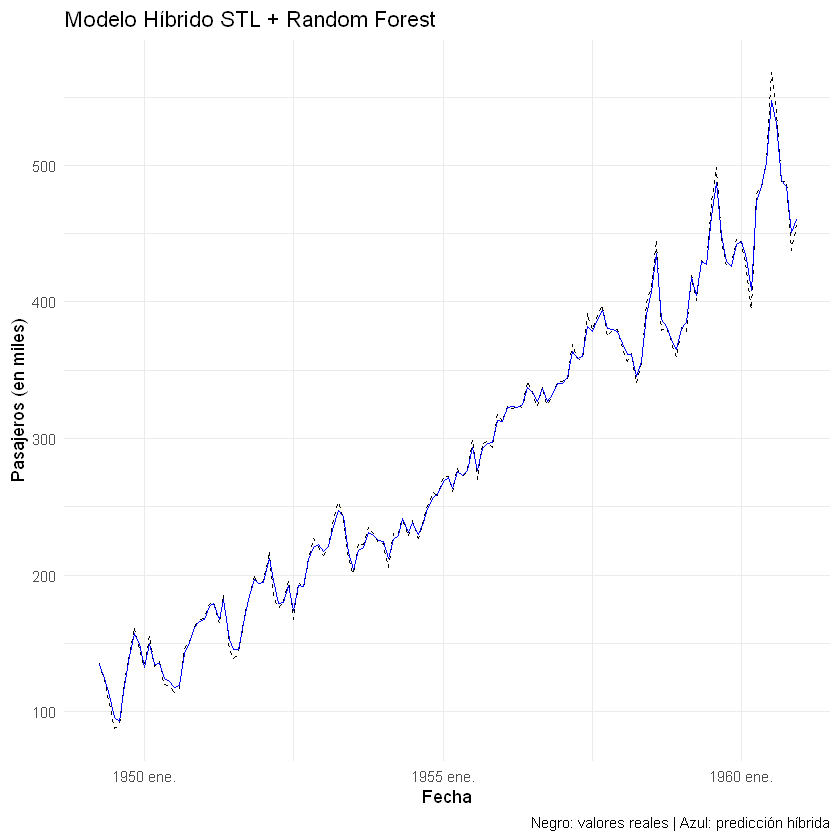

In [6]:
ggplot(df_hibrido, aes(x = index)) +
  geom_line(aes(y = season_adjust + remainder), color = "black", linetype = "dashed") +
  geom_line(aes(y = pred_hibrido), color = "blue") +
  labs(
    title = "Modelo Híbrido STL + Random Forest",
    y = "Pasajeros (en miles)",
    x = "Fecha",
    caption = "Negro: valores reales | Azul: predicción híbrida"
  ) +
  theme_minimal()


**7. Evaluar el desempeño**

Comparamos los residuos reales con los valores ajustados del modelo híbrido:


In [7]:
library(yardstick)

df_hibrido %>%
  mutate(real = season_adjust + remainder) %>%
  metrics(truth = real, estimate = pred_hibrido) %>%
  print()



Adjuntando el paquete: 'yardstick'


The following object is masked from 'package:fabletools':

    accuracy




# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard       4.55 
2 rsq     standard       0.998
3 mae     standard       3.24 


**Pronósticos a futuro del modelo híbrido**

Aunque randomForest no tiene una estructura de predicción autoregresiva automática como los modelos clásicos, podemos construir una predicción paso a paso hacia adelante usando una estrategia autoregresiva sobre los residuos.

**🔮 Proyección hacia el futuro con modelo híbrido STL + Random Forest**

🛠 Paso 1: Definir cuántos pasos quieres predecir

In [8]:
h <- 12  # por ejemplo, 12 meses adelante

🛠 Paso 2: Obtener la serie STL y sus componentes


In [9]:
modelo_stl <- ap_ts %>% model(STL = STL(value))
componentes <- components(modelo_stl)


🛠 Paso 3: Proyectar el componente tradicional (usamos `ETS` sobre la serie desestacionalizada)

In [10]:
modelo_ets_stl <- componentes %>%
  select(index, season_adjust) %>%
  model(ETS_stl = ETS(season_adjust))

# Forecast del componente desestacionalizado
pred_sa <- modelo_ets_stl %>% forecast(h = h)

# Extraer valores pronosticados
valores_sa <- pred_sa %>% as_tibble() %>% pull(.mean)


🛠 Paso 4: Proyectar la estacionalidad repitiendo el último ciclo completo

In [11]:
ultima_estacionalidad <- tail(componentes$season_year, 12)
pred_estacionalidad <- rep(ultima_estacionalidad, length.out = h)

🛠 Paso 5: Crear índice de fechas futuras (como `yearmonth`)

In [12]:
ult_fecha <- max(componentes$index)
fechas_futuras <- ult_fecha + 1:h  # Avanza h meses en yearmonth

🛠 Paso 6: Crear tabla con predicción ETS + estacionalidad

In [13]:
df_futuro <- tibble(
  index = fechas_futuras,
  season_adjust = valores_sa,
  seasonal = pred_estacionalidad
)


🛠 Paso 7: Proyectar los residuos con Random Forest autoregresivo

In [14]:
# Crear dataset de entrenamiento de residuos
residuos_df <- componentes %>%
  as_tibble() %>%
  mutate(
    lag1 = lag(remainder, 1),
    lag2 = lag(remainder, 2),
    lag3 = lag(remainder, 3)
  ) %>%
  drop_na()

# Ajustar modelo Random Forest
modelo_rf <- randomForest(remainder ~ lag1 + lag2 + lag3, data = residuos_df)

# Semilla: últimos 3 residuos
ultimos_residuos <- tail(componentes$remainder, 3)

# Predicción autoregresiva paso a paso
residuos_pred <- numeric(h)
for (i in 1:h) {
  nuevo <- data.frame(
    lag1 = ultimos_residuos[length(ultimos_residuos)],
    lag2 = ultimos_residuos[length(ultimos_residuos) - 1],
    lag3 = ultimos_residuos[length(ultimos_residuos) - 2]
  )
  pred <- predict(modelo_rf, newdata = nuevo)
  residuos_pred[i] <- pred
  ultimos_residuos <- c(ultimos_residuos, pred)
}


🛠 Paso 8: Combinar todo y obtener el pronóstico híbrido

In [15]:
df_futuro <- df_futuro %>%
  mutate(
    pred_rf = residuos_pred,
    pred_hibrido = season_adjust + seasonal + pred_rf
  )

📈 Visualización de la proyección

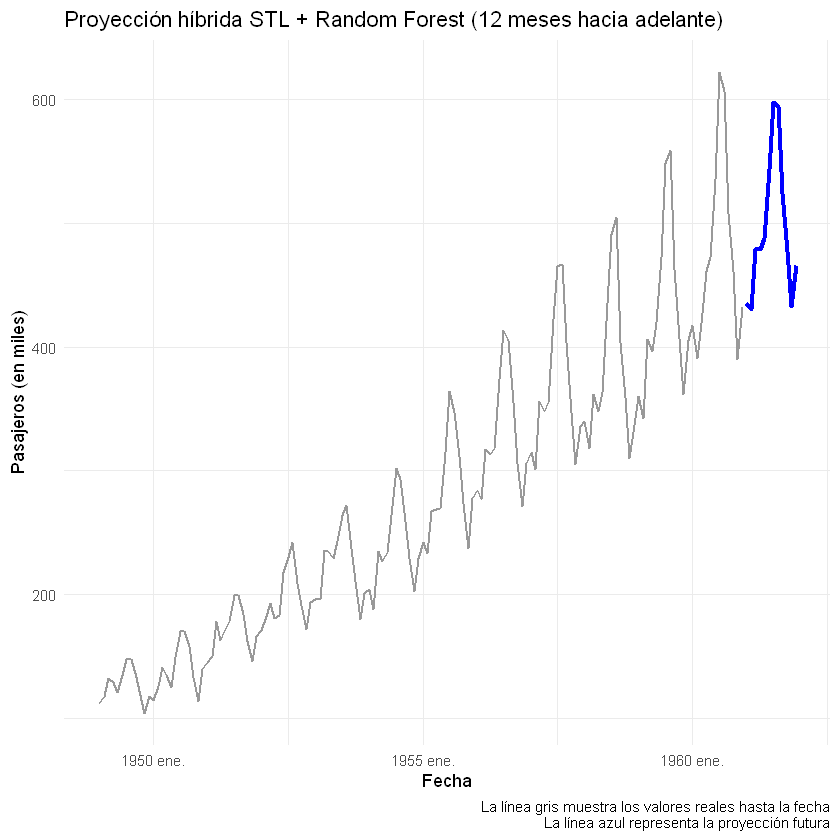

In [16]:
# Convertir la serie original a tsibble si no lo está
ap_ts <- as_tsibble(AirPassengers)

# Visualizar la serie original + predicción
ggplot() +
  geom_line(data = ap_ts, aes(x = index, y = value), color = "gray60", linewidth = 0.8) +
  geom_line(data = df_futuro, aes(x = index, y = pred_hibrido), color = "blue", linewidth = 1.2) +
  labs(
    title = "Proyección híbrida STL + Random Forest (12 meses hacia adelante)",
    x = "Fecha", y = "Pasajeros (en miles)",
    caption = "La línea gris muestra los valores reales hasta la fecha\nLa línea azul representa la proyección futura"
  ) +
  theme_minimal()


<h3>📝 Preguntas de reflexión para el taller</h3>

1. ¿Qué mejoras se observan en el modelo híbrido respecto al componente estadístico solo?
2. ¿Qué pasaría si se incluyen más lags? ¿Y si se usa otra técnica como `xgboost`?
3. ¿Qué ventajas ofrece Random Forest frente a redes neuronales en este caso?
4. ¿Qué desafíos se presentarían al aplicar este modelo sobre datos reales con efectos exógenos?
